In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/Alzheimers disease.zip'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from pathlib import Path
import random
import cv2
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os, zipfile

# Extract the zip file
with zipfile.ZipFile("/content/Alzheimers disease.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/Alzheimers_disease")  # Extract to a directory

# Now list the contents of the extracted directory
total_classes = os.listdir("/content/Alzheimers_disease")
print(total_classes)

['Very_Mild_Demented', 'Moderate_Demented', 'Mild_Demented', 'Non_Demented']


In [4]:
# Total number of images per class.
images_path = Path("/content/Alzheimers_disease")

for c in total_classes:
  print(f'* {c}', '=',len(os.listdir(os.path.join(images_path, c))), 'images')

* Very_Mild_Demented = 2240 images
* Moderate_Demented = 64 images
* Mild_Demented = 896 images
* Non_Demented = 3200 images


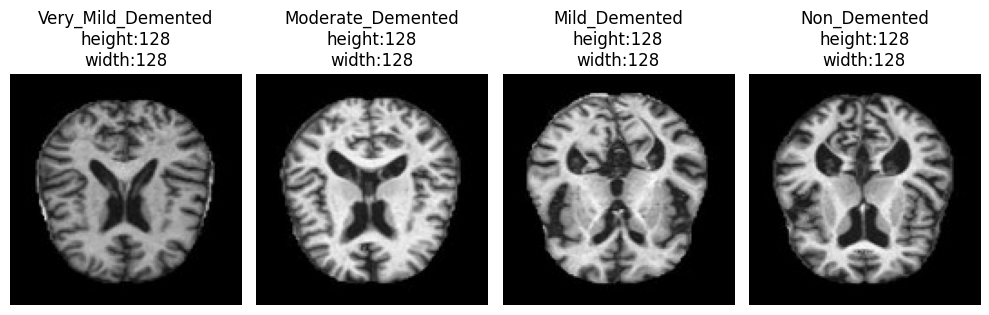

In [5]:
# Let's display 1 image per class.

fig,ax = plt.subplots(1,4,figsize=(10,4))
ax = ax.flat
for i,c in enumerate(total_classes):
  img_total_class = list(Path(os.path.join(images_path, c)).glob("*.jpg"))
  img_selected = random.choice(img_total_class)
  img_BGR = cv2.imread(str(img_selected))
  img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
  height,width,channel = img_RGB.shape
  ax[i].imshow(img_RGB)
  ax[i].set_title(f"{img_selected.parent.stem}\nheight:{height}\nwidth:{width}")
  ax[i].axis("off")

fig.tight_layout()
fig.show()

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size)

Found 6400 files belonging to 4 classes.
Using 5120 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


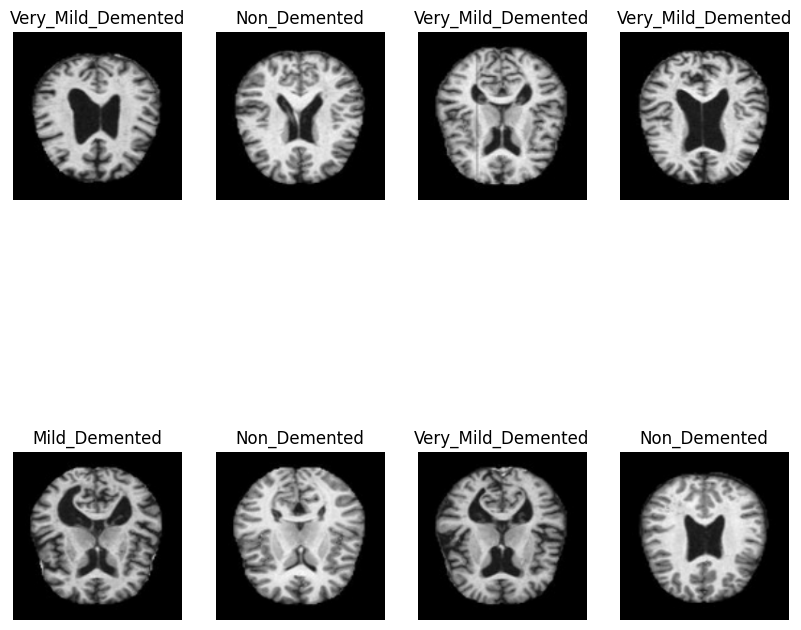

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Standardizing the dataset**

In [13]:
normalization_layer = layers.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in '[0,1]'

print(np.min(first_image), np.max(first_image))

0.0 0.9810989


**Creating the model**

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [16]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes)
])

In [17]:
model.compile(optimizer="adam",
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,156 (15.22 MB)

 Trainable params: 3,989,156 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

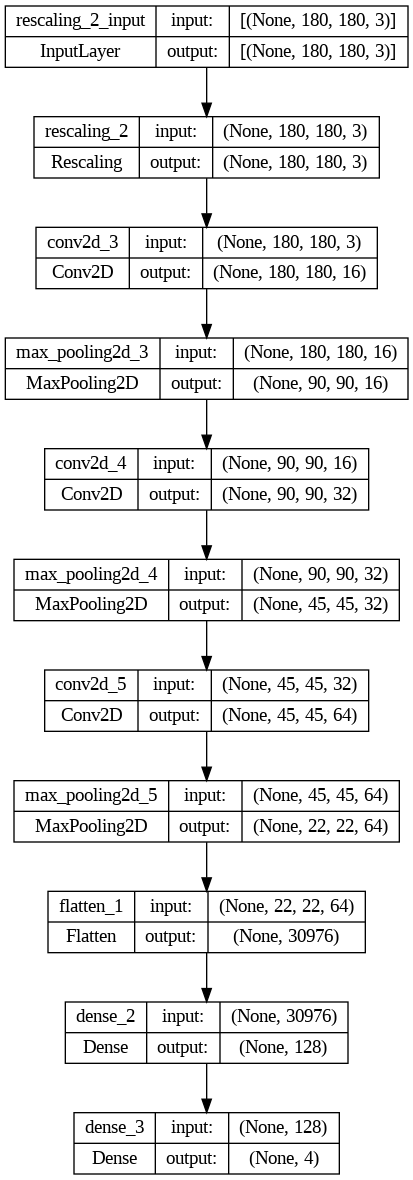

In [ ]:
from tensorflow.keras.utils import plot_model
# Save the model summary as an image
plot_model(model, to_file='CNN_100_model_summary_before_Data_Aug.png', show_shapes=True, show_layer_names=True)

In [19]:
epochs = 100

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping])

Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.4967 - loss: 1.0211 - val_accuracy: 0.6344 - val_loss: 0.7900
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6888 - loss: 0.7227 - val_accuracy: 0.7320 - val_loss: 0.6183
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8614 - loss: 0.3775 - val_accuracy: 0.8898 - val_loss: 0.2798
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9631 - loss: 0.1174 - val_accuracy: 0.9445 - val_loss: 0.1426
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9900 - loss: 0.0397 - val_accuracy: 0.9750 - val_loss: 0.0726
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9951 - loss: 0.0195 - val_accuracy: 0.9352 - val_loss: 0.1372
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9882 - loss: 0.0337 - val_accuracy: 0.9375 - val_loss: 0.1552
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9894 - loss: 0.0282 -

**Visualization of results**

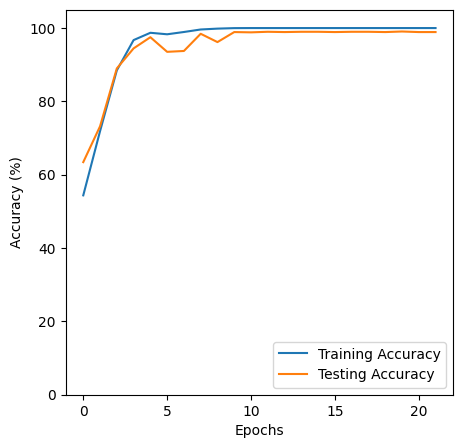

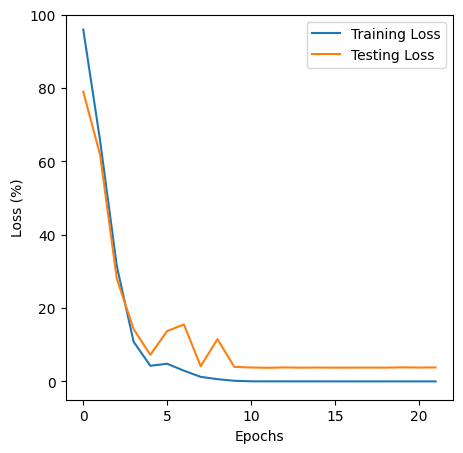

In [20]:
import matplotlib.pyplot as plt

acc = [a * 100 for a in history.history['accuracy']]
val_acc = [a * 100 for a in history.history['val_accuracy']]

loss = [b * 100 for b in history.history['loss']]
val_loss = [b * 100 for b in history.history['val_loss']]

epochs_range = range(len(acc))  # Use the length of the accuracy list

# Plot Training and Validation Accuracy
plt.figure(figsize=(5, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epochs')
plt.ylim([0, 105])  # Set the y-axis limit from 0 to 100
# Save the accuracy plot
plt.savefig('CNN_100_training_testing_accuracy_before_Data_Aug.png')  # You can change the path and filename as needed
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(5, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Testing Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss (%)')
plt.xlabel('Epochs')
plt.ylim([-5, 100])
# Save the loss plot
plt.savefig('CNN_100_training_testing_loss_before_Data_Aug.png')  # You can change the path and filename as needed
plt.show()


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


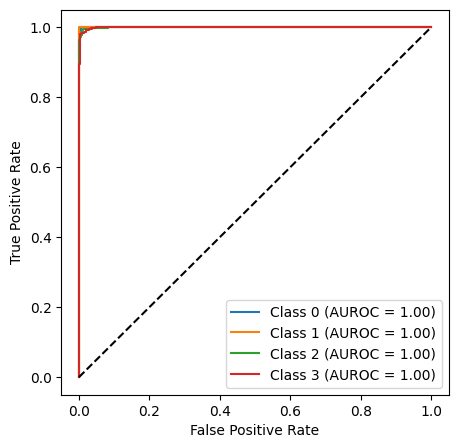

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Get predictions and true labels
y_pred_logits = model.predict(val_ds)
y_pred_probs = tf.nn.softmax(y_pred_logits).numpy()  # Convert logits to probabilities
y_true = np.concatenate([y for x, y in val_ds], axis=0)  # True labels for the validation set

# If it's a multi-class problem, binarize the labels for AUROC calculation
y_true_binarized = label_binarize(y_true, classes=np.arange(num_classes))

# Create a single figure for plotting all ROC curves
plt.figure(figsize=(5, 5))

# Calculate AUROC for each class and plot
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUROC = {roc_auc:.2f})')

# Plot the diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Show the combined plot with all ROC curves
plt.savefig('CNN_100_AUROC_before_Data_Aug.png')
plt.show()


In [25]:
model.evaluate(val_ds)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9911 - loss: 0.0328


[0.03713405877351761, 0.9898437261581421]

In [26]:
model.evaluate(train_ds)

160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 1.3055e-04


[0.00011676743451971561, 1.0]

**Augumentation**

In [27]:
data_augmentation = keras.Sequential(
[
    layers.RandomFlip("horizontal",
                     input_shape=(img_height,
                                 img_width,
                                  3)),

    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

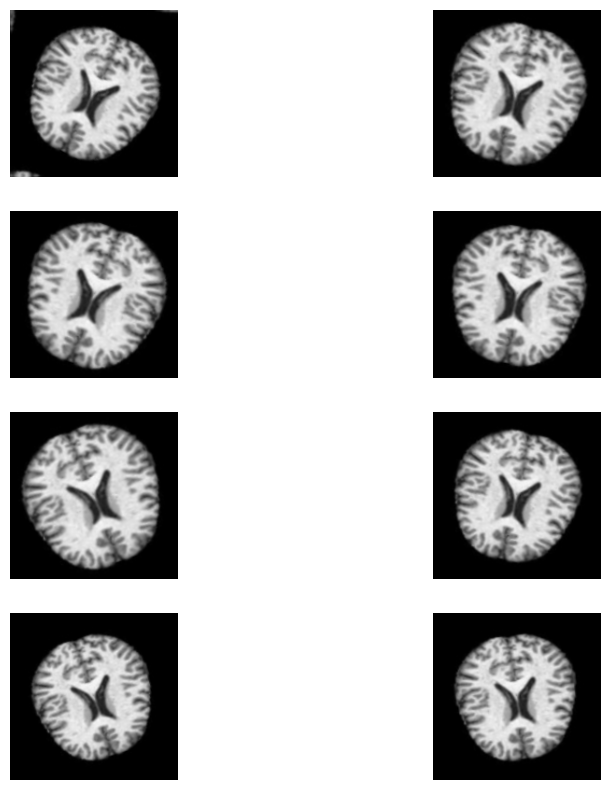

In [28]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(8):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(4,2, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Adding a dropout layer**

In [29]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes)
])

In [30]:
model.compile(optimizer="adam",
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])

In [31]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,156 (15.22 MB)

 Trainable params: 3,989,156 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

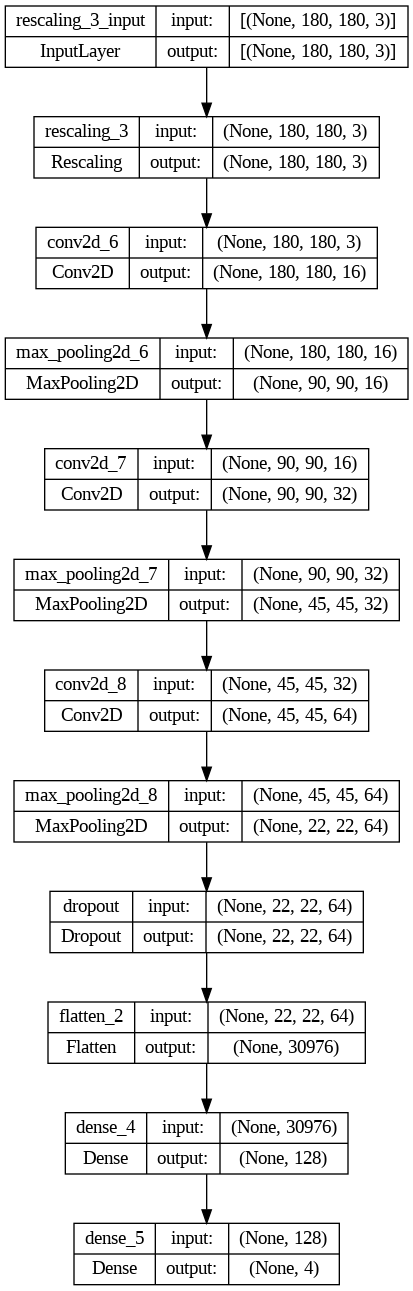

In [ ]:
from tensorflow.keras.utils import plot_model
# Save the model summary as an image
plot_model(model, to_file='CNN_100_model_summary_after_Data_Aug.png', show_shapes=True, show_layer_names=True)

In [37]:
epochs = 100

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping])

Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8347 - loss: 0.3994 - val_accuracy: 0.8750 - val_loss: 0.2872
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9170 - loss: 0.2128 - val_accuracy: 0.8727 - val_loss: 0.3040
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9378 - loss: 0.1719 - val_accuracy: 0.9422 - val_loss: 0.1602
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9577 - loss: 0.1157 - val_accuracy: 0.9719 - val_loss: 0.0810
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9778 - loss: 0.0636 - val_accuracy: 0.9703 - val_loss: 0.0937
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9767 - loss: 0.0713 - val_accuracy: 0.9516 - val_loss: 0.1245
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9866 - loss: 0.0380 - val_accuracy: 0.9680 - val_loss: 0.0896
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9889 - loss: 0.0342 - 

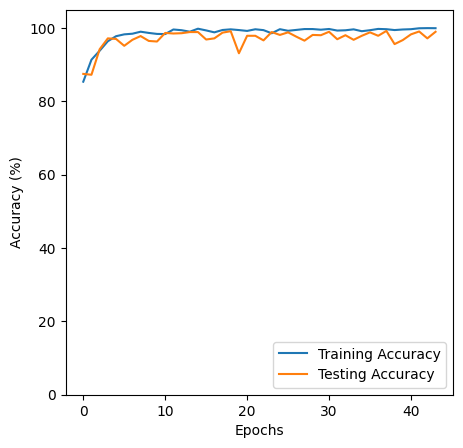

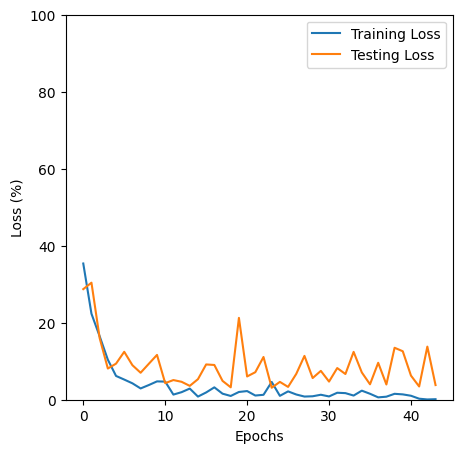

In [38]:
import matplotlib.pyplot as plt

acc = [a * 100 for a in history.history['accuracy']]
val_acc = [a * 100 for a in history.history['val_accuracy']]

loss = [b * 100 for b in history.history['loss']]
val_loss = [b * 100 for b in history.history['val_loss']]

epochs_range = range(len(acc))

# Plot Training and Validation Accuracy
plt.figure(figsize=(5, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
#plt.title("Training and Validation Accuracy")
plt.ylabel('Accuracy (%)')
plt.xlabel('Epochs')
plt.ylim([0, 105])  # Set the y-axis limit from 0 to 100
# Save the accuracy plot
plt.savefig('CNN_100_training_testing_accuracy_after_Data_Aug.png')  # You can change the path and filename as needed
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(5, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Testing Loss')
plt.legend(loc='upper right')
#plt.title('Training and Validation Loss')
plt.ylabel('Loss (%)')
plt.xlabel('Epochs')
plt.ylim([0, 100])
# Save the loss plot
plt.savefig('CNN_100_training_testing_loss_after_Data_Aug.png')  # You can change the path and filename as needed
plt.show()


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


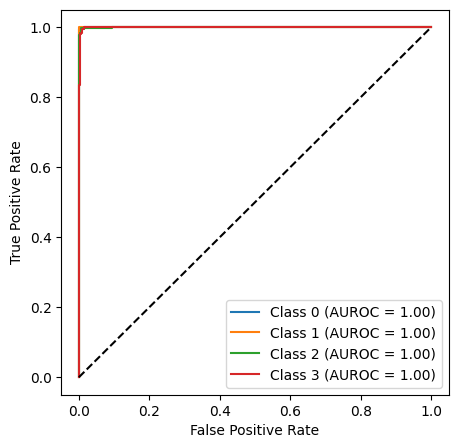

In [39]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Get predictions and true labels
y_pred_logits = model.predict(val_ds)
y_pred_probs = tf.nn.softmax(y_pred_logits).numpy()  # Convert logits to probabilities
y_true = np.concatenate([y for x, y in val_ds], axis=0)  # True labels for the validation set

# If it's a multi-class problem, binarize the labels for AUROC calculation
y_true_binarized = label_binarize(y_true, classes=np.arange(num_classes))

# Create a single figure for plotting all ROC curves
plt.figure(figsize=(5, 5))

# Calculate AUROC for each class and plot
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUROC = {roc_auc:.2f})')

# Plot the diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Show the combined plot with all ROC curves
plt.savefig('CNN_100_AUROC_after_Data_Aug.png')
plt.show()


In [40]:
model.evaluate(train_ds)

160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9990 - loss: 0.0027


[0.0024953309912234545, 0.9990234375]

In [41]:
model.evaluate(val_ds)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9845 - loss: 0.0445


[0.031154939904808998, 0.989062488079071]

In [ ]:
# Save the Keras model as an HDF5 file
model.save("CNN_100_alzeihmer_model_new.h5")

In [ ]:
# 21BCE9757